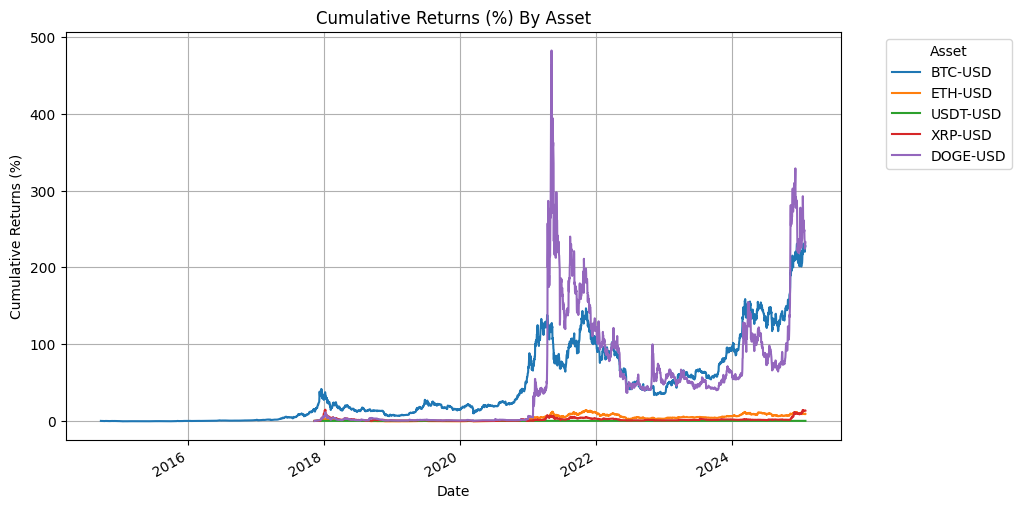


Normalized Cumulative Returns:
BTC-USD Cumulative Returns:
Date
2014-09-18 00:00:00+00:00   -0.071926
2014-09-19 00:00:00+00:00   -0.136745
2014-09-20 00:00:00+00:00   -0.105896
2014-09-21 00:00:00+00:00   -0.127944
2014-09-22 00:00:00+00:00   -0.120660
Name: Close, dtype: float64
ETH-USD Cumulative Returns:
Date
2017-11-10 00:00:00+00:00   -0.067411
2017-11-11 00:00:00+00:00   -0.019331
2017-11-12 00:00:00+00:00   -0.040438
2017-11-13 00:00:00+00:00   -0.012989
2017-11-14 00:00:00+00:00    0.052190
Name: Close, dtype: float64
USDT-USD Cumulative Returns:
Date
2017-11-10 00:00:00+00:00   -0.002152
2017-11-11 00:00:00+00:00    0.000803
2017-11-12 00:00:00+00:00    0.004255
2017-11-13 00:00:00+00:00    0.001160
2017-11-14 00:00:00+00:00   -0.001339
Name: Close, dtype: float64
XRP-USD Cumulative Returns:
Date
2017-11-10 00:00:00+00:00   -0.050600
2017-11-11 00:00:00+00:00   -0.032452
2017-11-12 00:00:00+00:00   -0.092644
2017-11-13 00:00:00+00:00   -0.064583
2017-11-14 00:00:00+00:00   -

100%|██████████| 6/6 [00:01<00:00,  4.01it/s]


In [ ]:
import warnings
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import bt

warnings.simplefilter(action='ignore', category=FutureWarning)

coin_ids = [
    'BTC-USD',  # Bitcoin
    'ETH-USD',  # Ethereum
    'USDT-USD',  # Tether
    'XRP-USD',  # Ripple
    'DOGE-USD'  # Dogecoin
]


historical_data = {coin: yf.Ticker(coin).history(period="max") for coin in coin_ids}
historical_prices = {coin: data['Close'] for coin, data in historical_data.items()}
historical_volume = {coin: data['Volume'] for coin, data in historical_data.items()}


normalized_historical_prices = {coin: prices / prices.iloc[0] * 100 for coin, prices in historical_prices.items()}

historical_returns = {coin: prices.pct_change().dropna() for coin, prices in normalized_historical_prices.items()}

normalized_cumulative_returns = {coin: (1 + returns).cumprod() - 1 for coin, returns in historical_returns.items()}


plt.figure(figsize=(10, 6))
for coin, cumulative_returns in normalized_cumulative_returns.items():
    cumulative_returns.plot(label=coin)

plt.title('Cumulative Returns (%) By Asset')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (%)')
plt.grid(True)
plt.legend(title='Asset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print('\nNormalized Cumulative Returns:')
for coin, cumulative_returns in normalized_cumulative_returns.items():
    print(f'{coin} Cumulative Returns:')
    print(cumulative_returns.head())


btc_strategy = bt.Strategy('Bitcoin',
                           [bt.algos.RunOnce(),
                            bt.algos.SelectThese(['BTC-USD']),
                            bt.algos.WeighEqually(),
                            bt.algos.Rebalance()])

eth_strategy = bt.Strategy('Ethereum',
                           [bt.algos.RunOnce(),
                            bt.algos.SelectThese(['ETH-USD']),
                            bt.algos.WeighEqually(),
                            bt.algos.Rebalance()])

ew_strategy = bt.Strategy('Equal-Weighted',
                          [bt.algos.RunMonthly(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

random_strategy = bt.Strategy('Random-Weighted',
                              [bt.algos.RunMonthly(),
                               bt.algos.SelectRandomly(),
                               bt.algos.WeighRandomly(),
                               bt.algos.Rebalance()])


lookback_period = pd.DateOffset(months=3)


start_date = list(normalized_historical_prices.values())[0].index.min() + lookback_period

erc_strategy = bt.Strategy('Risk Parity', [
    bt.algos.RunAfterDate(start_date),
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighERC(lookback=lookback_period, covar_method='ledoit-wolf'),
    bt.algos.Rebalance()
])

# Mean-Variance Optimization strategy
mvo_strategy = bt.Strategy('Mean-Variance', [
    bt.algos.RunAfterDate(start_date),
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighMeanVar(
        lookback=lookback_period,
        bounds=(0.0, 0.5),
        covar_method='ledoit-wolf'
    ),
    bt.algos.Rebalance()
])


price_data = pd.DataFrame(normalized_historical_prices)
price_data.index.name = 'Date'


portfolio = bt.Backtest(btc_strategy, price_data)
portfolio_eth = bt.Backtest(eth_strategy, price_data)
portfolio_ew = bt.Backtest(ew_strategy, price_data)
portfolio_random = bt.Backtest(random_strategy, price_data)
portfolio_erc = bt.Backtest(erc_strategy, price_data)
portfolio_mvo = bt.Backtest(mvo_strategy, price_data)

result = bt.run(portfolio, portfolio_eth, portfolio_ew, portfolio_random, portfolio_erc, portfolio_mvo)



100%|██████████| 6/6 [00:00<?, ?it/s]


[*********************100%%**********************]  1 of 1 completed

Average Risk-Free Rate: 2.49%


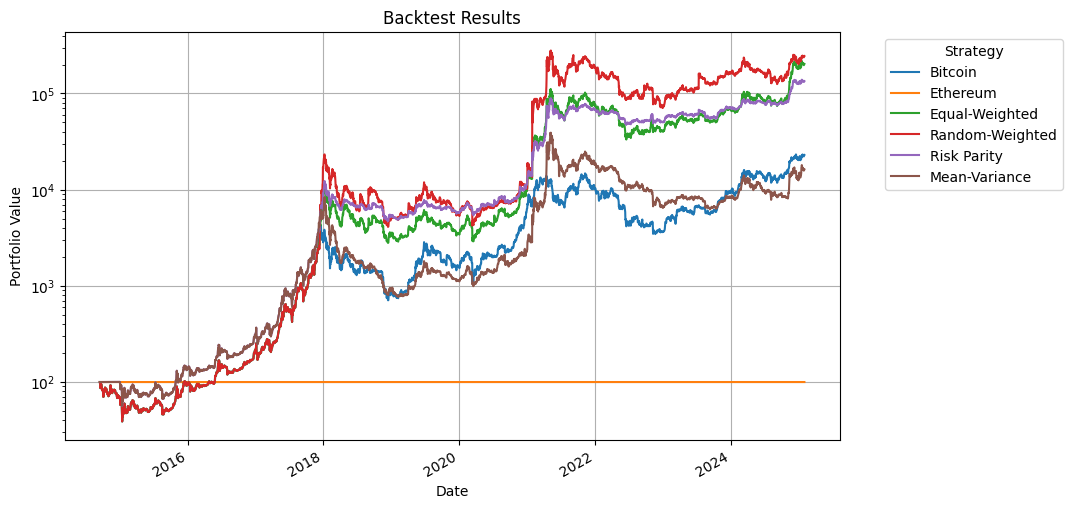

Stat                 Bitcoin     Ethereum    Equal-Weighted    Random-Weighted    Risk Parity    Mean-Variance
-------------------  ----------  ----------  ----------------  -----------------  -------------  ---------------
Start                2014-09-16  2014-09-16  2014-09-16        2014-09-16         2014-09-16     2014-09-16
End                  2025-01-31  2025-01-31  2025-01-31        2025-01-31         2025-01-31     2025-01-31
Risk-free rate       2.49%       2.49%       2.49%             2.49%              2.49%          2.49%

Total Return         22817.52%   0.00%       202537.66%        244516.80%         134054.71%     16128.42%
Daily Sharpe         0.88        -inf        1.09              0.76               1.22           0.81
Daily Sortino        1.44        -inf        1.96              2.31               2.14           1.41
CAGR                 68.83%      0.00%       108.29%           112.11%            100.18%        63.31%
Max Drawdown         -83.40%     0.00%   

In [15]:
import bt


price_data = pd.DataFrame(normalized_historical_prices)
price_data.index.name = 'Date'

btc_backtest = bt.Backtest(btc_strategy, price_data)
eth_backtest = bt.Backtest(eth_strategy, price_data)
ew_backtest = bt.Backtest(ew_strategy, price_data)
mw_backtest = bt.Backtest(random_strategy, price_data) 
erc_backtest = bt.Backtest(erc_strategy, price_data)
mvo_backtest = bt.Backtest(mvo_strategy, price_data)


backtests_dict = {
    btc_backtest.name: btc_backtest,
    eth_backtest.name: eth_backtest,
    ew_backtest.name: ew_backtest,
    mw_backtest.name: mw_backtest,
    erc_backtest.name: erc_backtest,
    mvo_backtest.name: mvo_backtest,
}


btc_results = bt.run(btc_backtest)
eth_results = bt.run(eth_backtest)
ew_results = bt.run(ew_backtest)
mw_results = bt.run(mw_backtest)
erc_results = bt.run(erc_backtest)
mvo_results = bt.run(mvo_backtest)

total_results = bt.run(
    btc_backtest,
    eth_backtest,
    ew_backtest,
    mw_backtest,
    erc_backtest,
    mvo_backtest,
)


start_date = price_data.index.min()
end_date = price_data.index.max()

# Get historical risk-free rate (e.g., from the 10-year treasury yield)
risk_free_rate = round(bt.get(
    '^TNX',
    start=start_date,
    end=end_date
).mean().values[0] / 100, 4)


print('\nAverage Risk-Free Rate: {}%'.format(round(risk_free_rate * 100, 2)))

# Set the risk-free rate for all results
btc_results.set_riskfree_rate(risk_free_rate)
eth_results.set_riskfree_rate(risk_free_rate)
ew_results.set_riskfree_rate(risk_free_rate)
mw_results.set_riskfree_rate(risk_free_rate)
erc_results.set_riskfree_rate(risk_free_rate)
mvo_results.set_riskfree_rate(risk_free_rate)
total_results.set_riskfree_rate(risk_free_rate)


total_results.plot(figsize=(10, 6))
plt.title('Backtest Results')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.yscale('log')
plt.show()

total_results.display()
